# ***Machine Learning model selection***

### ***Description***
Select the best machine learning model for the NYC HOUSES dataset.
The models at least has to be better than the baseline model (heuristic approach). 

## 📚 ***Import libraries***

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

## 💾 ***Load data***

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

nyc_houses_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/nyc_houses_semi_cleaned.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility
print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


In [4]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29179 entries, 0 to 29178
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMMERCIAL UNITS           29178 non-null  Int64  
 1   TAX CLASS AT TIME OF SALE  29179 non-null  float64
 2   RESIDENTIAL UNITS          29179 non-null  Int64  
 3   GROSS SQUARE FEET          22359 non-null  float64
 4   BOROUGH                    29179 non-null  float64
 5   SALE PRICE                 29179 non-null  float64
 6   YEAR BUILT                 27797 non-null  float64
 7   LAND SQUARE FEET           22700 non-null  float64
dtypes: Int64(2), float64(6)
memory usage: 1.8 MB


## 👷 ***Data preparation***

***All columns will be used as this data file is already processed with the respective analysis of which columns may be relevant to the target variable.***

In [5]:
nyc_houses_df.isna().sum()

COMMERCIAL UNITS                1
TAX CLASS AT TIME OF SALE       0
RESIDENTIAL UNITS               0
GROSS SQUARE FEET            6820
BOROUGH                         0
SALE PRICE                      0
YEAR BUILT                   1382
LAND SQUARE FEET             6479
dtype: int64

In [6]:
nyc_houses_df = nyc_houses_df.drop_duplicates()
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28142 entries, 0 to 29178
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMMERCIAL UNITS           28141 non-null  Int64  
 1   TAX CLASS AT TIME OF SALE  28142 non-null  float64
 2   RESIDENTIAL UNITS          28142 non-null  Int64  
 3   GROSS SQUARE FEET          22231 non-null  float64
 4   BOROUGH                    28142 non-null  float64
 5   SALE PRICE                 28142 non-null  float64
 6   YEAR BUILT                 27099 non-null  float64
 7   LAND SQUARE FEET           22566 non-null  float64
dtypes: Int64(2), float64(6)
memory usage: 2.0 MB


In [7]:
nyc_houses_df["TAX CLASS AT TIME OF SALE"] = nyc_houses_df["TAX CLASS AT TIME OF SALE"].astype("category")
nyc_houses_df["BOROUGH"] = nyc_houses_df["BOROUGH"].astype("category")

In [8]:
nyc_houses_df.isna().sum()

COMMERCIAL UNITS                1
TAX CLASS AT TIME OF SALE       0
RESIDENTIAL UNITS               0
GROSS SQUARE FEET            5911
BOROUGH                         0
SALE PRICE                      0
YEAR BUILT                   1043
LAND SQUARE FEET             5576
dtype: int64

In [9]:
nyc_houses_df.sample(10, random_state=42)

,COMMERCIAL UNITS,TAX CLASS AT TIME OF SALE,RESIDENTIAL UNITS,GROSS SQUARE FEET,BOROUGH,SALE PRICE,YEAR BUILT,LAND SQUARE FEET
20138,0,1.0,2,1820.0,4.0,850000.0,1920.0,2500.0
7988,0,1.0,1,923.0,4.0,425000.0,1920.0,2002.0
25659,0,1.0,2,2288.0,4.0,1453000.0,1980.0,6000.0
26731,2,2.0,6,2118.0,1.0,1800000.0,1910.0,1680.0
24332,0,1.0,2,2298.0,3.0,1220000.0,1960.0,1718.0
7148,0,1.0,2,2072.0,4.0,400000.0,2007.0,2166.0
12177,0,1.0,1,1144.0,4.0,538000.0,1920.0,1800.0
486,0,2.0,0,NaN,3.0,72000.0,1966.0,NaN
16078,0,2.0,0,NaN,3.0,665000.0,1944.0,NaN
4514,0,1.0,1,1368.0,3.0,310000.0,1899.0,1425.0


## 👨‍🏭 ***Feature Engineering***

In [10]:
numeric_features = ["GROSS SQUARE FEET", "LAND SQUARE FEET", "COMMERCIAL UNITS", "RESIDENTIAL UNITS"]
categorical_features = ["TAX CLASS AT TIME OF SALE", "BOROUGH"]
ordinal_features = ["YEAR BUILT"]

In [11]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, numeric_features),
        ("categoric", categorical_pipe, categorical_features),
        ("ordinal", categorical_ord_pipe, ordinal_features),
    ]
)

In [12]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['GROSS SQUARE FEET', 'LAND SQUARE FEET',
                                  'COMMERCIAL UNITS', 'RESIDENTIAL UNITS']),
                                ('categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['TAX CLASS AT TIME OF SALE', 'BOROUGH']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['YEAR BUILT'])])

***Train / Test split***

In [13]:
X_features = nyc_houses_df.drop("SALE PRICE", axis="columns")
Y_target = nyc_houses_df["SALE PRICE"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

In [14]:
x_train.shape, y_train.shape

((22513, 7), (22513,))

In [15]:
x_test.shape, y_test.shape

((5629, 7), (5629,))

***Example of the data preprocessing pipeline***

In [16]:
# Train the preprocessing pipeline
preprocessor.fit(x_train)

# Get the output column names from the preprocessing step
# using .get_feature_names_out()
feature_names = preprocessor.get_feature_names_out()

# Transform x_test using the preprocessor and convert it to a pandas DataFrame
x_test_transformed = preprocessor.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=feature_names)
x_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5629 entries, 0 to 5628
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   numeric__GROSS SQUARE FEET                5629 non-null   float64
 1   numeric__LAND SQUARE FEET                 5629 non-null   float64
 2   numeric__COMMERCIAL UNITS                 5629 non-null   float64
 3   numeric__RESIDENTIAL UNITS                5629 non-null   float64
 4   categoric__TAX CLASS AT TIME OF SALE_1.0  5629 non-null   float64
 5   categoric__TAX CLASS AT TIME OF SALE_2.0  5629 non-null   float64
 6   categoric__TAX CLASS AT TIME OF SALE_4.0  5629 non-null   float64
 7   categoric__BOROUGH_1.0                    5629 non-null   float64
 8   categoric__BOROUGH_2.0                    5629 non-null   float64
 9   categoric__BOROUGH_3.0                    5629 non-null   float64
 10  categoric__BOROUGH_4.0              

In [17]:
x_test_transformed.sample(5)

,numeric__GROSS SQUARE FEET,numeric__LAND SQUARE FEET,numeric__COMMERCIAL UNITS,numeric__RESIDENTIAL UNITS,categoric__TAX CLASS AT TIME OF SALE_1.0,categoric__TAX CLASS AT TIME OF SALE_2.0,categoric__TAX CLASS AT TIME OF SALE_4.0,categoric__BOROUGH_1.0,categoric__BOROUGH_2.0,categoric__BOROUGH_3.0,categoric__BOROUGH_4.0,categoric__BOROUGH_5.0,ordinal__YEAR BUILT
1115,1634.0,1900.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,140.0
2719,1065.0,1900.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0
4676,2346.0,2320.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,79.0
5372,1844.0,2500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,117.0
598,1276.0,4000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.0


# 🤖 ***Models***

Best Practices is to import the libraries at the beginning of the notebook, but for this notebook, the libraries are imported in the cell where they are used.

In this experiments Basic Machine Learning models are used, and the models are:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## ***Basic Model Selection***
The models are trained with the default hyperparameters, and the models with the best performance will be selected to be tuned in the next step

In [19]:
# Function to summarize regression metrics
def summarize_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

In [20]:
# Function to build, train, and evaluate regression model pipeline
def build_regression_model(regression_fn, 
                           preprocessor, 
                           data_params, 
                           test_frac=0.2, 
                           random_state=1234):
    """
    Train and evaluate a regression pipeline model.

    Args:
        regression_fn: Regression model instance (e.g., LinearRegression()).
        preprocessor (ColumnTransformer): preprocessing pipeline object
        data_params (dict): dictionary containing 'name_of_y_col', 'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data used for test set, default 0.2
        random_state (int): Random state for reproducibility

    Returns:
        dict: Performance metrics for train and test datasets and trained model pipeline
    """
    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate feature columns and target
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=random_state
    )

    # Pipeline: preprocessing + regression model
    regression_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", regression_fn)]
    )

    # Train pipeline
    regression_pipeline.fit(x_train, y_train)

    # Predictions
    y_pred_train = regression_pipeline.predict(x_train)
    y_pred_test = regression_pipeline.predict(x_test)

    # Evaluation metrics
    train_summary = summarize_regression(y_train, y_pred_train)
    test_summary = summarize_regression(y_test, y_pred_test)

    return {
        "train_metrics": train_summary,
        "test_metrics": test_summary,
        "trained_model": regression_pipeline
    }


## ***First Selection of Models***
The idea is to do a simple train an evaluate the models to see which ones are the worts to discard them.

In [21]:
FEATURES = list(X_features.columns)
FEATURES

['COMMERCIAL UNITS',
 'TAX CLASS AT TIME OF SALE',
 'RESIDENTIAL UNITS',
 'GROSS SQUARE FEET',
 'BOROUGH',
 'YEAR BUILT',
 'LAND SQUARE FEET']

## ***Simple Train and Evaluate***

In [22]:
# Dictionary to store results
result_dict = {}

# Candidate regression models
models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "decision_tree": DecisionTreeRegressor(random_state=42),
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "svr": SVR(),
    "knn": KNeighborsRegressor(),
    "xgboost": XGBRegressor(random_state=42)
}

# Parameters of your dataset
data_params = {
    "name_of_y_col": "SALE PRICE",
    "names_of_x_cols": FEATURES,
    "dataset": nyc_houses_df,
}

In [23]:
# Train and evaluate models
for model_name, model in models.items():
    result_dict[model_name] = build_regression_model(
        regression_fn=model,
        preprocessor=preprocessor,
        data_params=data_params,
        test_frac=0.2,
        random_state=42
    )

C:\Users\SOULG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.782e+14, tolerance: 3.806e+12
  model = cd_fast.enet_coordinate_descent(


In [24]:
# Show the results clearly
for model_name, metrics in result_dict.items():
    print(f"--- {model_name.upper()} ---")
    print("Train:", metrics["train_metrics"])
    print("Test:", metrics["test_metrics"])
    print("\n")

--- LINEAR_REGRESSION ---
Train: {'MAE': 531102.2544852488, 'MSE': 1160341175779.6008, 'RMSE': np.float64(1077191.3366619695), 'R2': 0.3135537848372031}
Test: {'MAE': 518075.21532512276, 'MSE': 1123892998699.3271, 'RMSE': np.float64(1060138.19792484), 'R2': 0.31746911060838245}


--- RIDGE ---
Train: {'MAE': 531138.8663661908, 'MSE': 1160342297901.8525, 'RMSE': np.float64(1077191.8575174306), 'R2': 0.3135531210009205}
Test: {'MAE': 518107.9141913058, 'MSE': 1123896458066.4739, 'RMSE': np.float64(1060139.8294878246), 'R2': 0.31746700976342823}


--- LASSO ---
Train: {'MAE': 531102.6750046717, 'MSE': 1160341175883.33, 'RMSE': np.float64(1077191.3367101178), 'R2': 0.31355378477583784}
Test: {'MAE': 518075.4633489869, 'MSE': 1123892378786.189, 'RMSE': np.float64(1060137.9055510603), 'R2': 0.3174694870764857}


--- DECISION_TREE ---
Train: {'MAE': 86425.81221064007, 'MSE': 98613890873.74263, 'RMSE': np.float64(314028.4873602117), 'R2': 0.9416610100841448}
Test: {'MAE': 481558.6621353569, 'M

## ***Model Comparison***

In [25]:
# Model Comparison for Regression
metrics = ["RMSE", "R2"]
models = list(result_dict.keys())

# Prepare data for plotting
data_train = {
    metric: {model: result_dict[model]["train_metrics"][metric] for model in models}
    for metric in metrics
}

data_test = {
    metric: {model: result_dict[model]["test_metrics"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

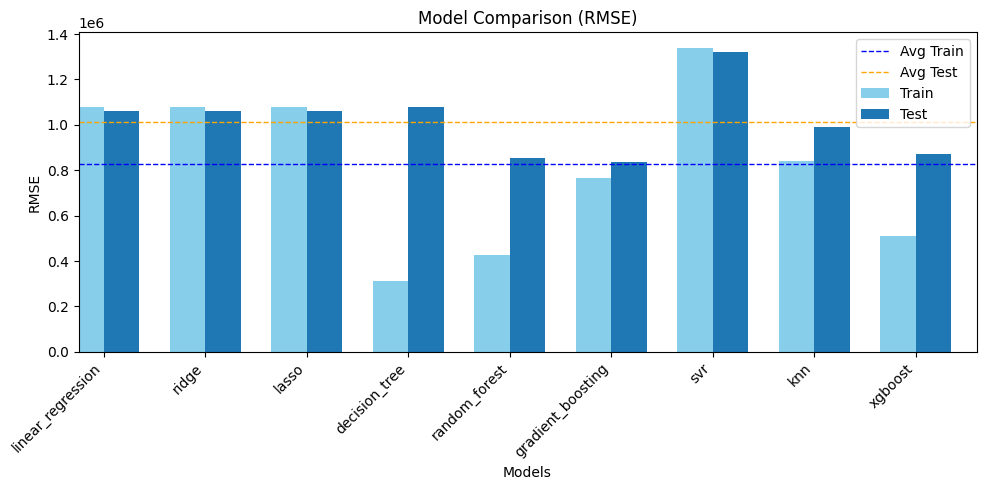

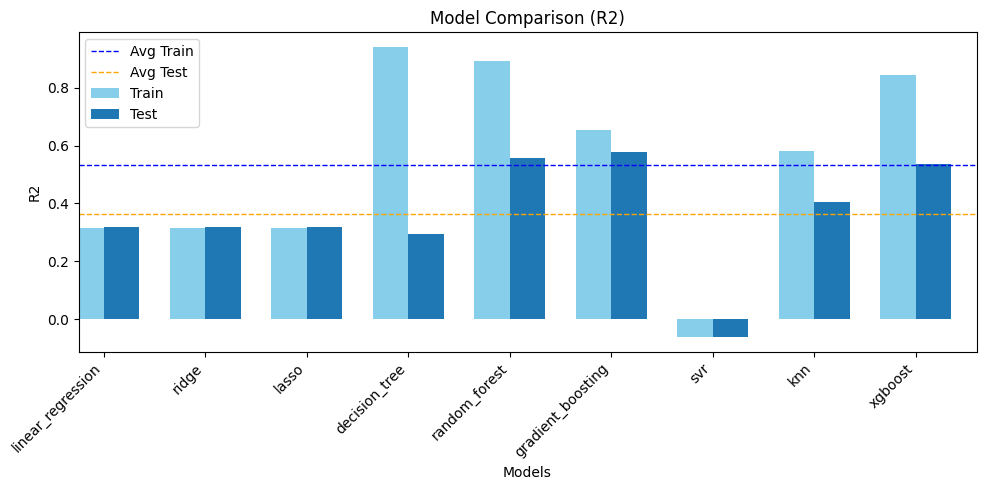

In [26]:
# Plot bar charts for RMSE and R² metrics
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.35

    # Plot Train and Test side by side
    df_train[metric].plot(kind="bar", ax=ax, width=width, position=1, label="Train", color="skyblue")
    df_test[metric].plot(kind="bar", ax=ax, width=width, position=0, label='Test')

    # Add average lines
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()

    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Customize the plot
    ax.set_title(f"Model Comparison ({metric})")
    ax.set_ylabel(metric)
    ax.set_xlabel("Models")
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
# Create a combined DataFrame with train and test metrics
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")],
    axis=1
)

# Calculate differences between train and test to detect overfitting
df_combined["RMSE_diff"] = np.abs(df_combined["RMSE_train"] - df_combined["RMSE_test"])
df_combined["R2_diff"] = np.abs(df_combined["R2_train"] - df_combined["R2_test"])

# Define thresholds for identifying overfitting and low performance
overfit_threshold = 0.2  # Adjust based on criteria (R2 difference)
low_perf_threshold = df_combined["R2_test"].mean()  # mean R2 as baseline for low performance

# Identify overfitting models (high difference between train and test R²)
overfitting_models = df_combined[
    df_combined["R2_train"] - df_combined["R2_test"] > overfit_threshold
]

# Identify low-performance models (below-average test R2)
low_performance_models = df_combined[df_combined["R2_test"] < low_perf_threshold]

# Print summary clearly
print(f"Models with overfitting: {list(overfitting_models.index)}")
print(f"Models with low performance: {list(low_performance_models.index)}")

Models with overfitting: ['decision_tree', 'random_forest', 'xgboost']
Models with low performance: ['linear_regression', 'ridge', 'lasso', 'decision_tree', 'svr']


In [28]:
# Detect models with similar performance in train and test (low difference indicates stable models)
similar_performance_threshold = 0.05  # Threshold for R2 difference to consider performance similar

similar_performance_models = df_combined[
    (df_combined["R2_diff"] < similar_performance_threshold)
]

print(
    "Models with similar performance in train and test: "
    f"{list(similar_performance_models.index)}"
)

Models with similar performance in train and test: ['linear_regression', 'ridge', 'lasso', 'svr']


In [29]:
overfitting_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff
decision_tree,314028.487360,0.941661,1.077901e+06,0.294405,763872.794824,0.647256
random_forest,424419.806520,0.893436,8.535695e+05,0.557539,429149.656130,0.335897
xgboost,511726.537865,0.845084,8.729449e+05,0.537224,361218.344025,0.307860


In [30]:
low_performance_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff
linear_regression,1.077191e+06,0.313554,1.060138e+06,0.317469,17053.138737,0.003915
ridge,1.077192e+06,0.313553,1.060140e+06,0.317467,17052.028030,0.003914
lasso,1.077191e+06,0.313554,1.060138e+06,0.317469,17053.431159,0.003916
decision_tree,3.140285e+05,0.941661,1.077901e+06,0.294405,763872.794824,0.647256
svr,1.340537e+06,-0.063110,1.321526e+06,-0.060592,19011.105332,0.002518


In [31]:
similar_performance_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff
linear_regression,1.077191e+06,0.313554,1.060138e+06,0.317469,17053.138737,0.003915
ridge,1.077192e+06,0.313553,1.060140e+06,0.317467,17052.028030,0.003914
lasso,1.077191e+06,0.313554,1.060138e+06,0.317469,17053.431159,0.003916
svr,1.340537e+06,-0.063110,1.321526e+06,-0.060592,19011.105332,0.002518


📌 ***Models to Discard:***

The following models showed poor performance either due to underfitting (low ability to capture variance) or extreme overfitting (large train-test performance gap):

- **Linear Regression** – Low R² (0.31), high RMSE (~1,060,000), indicating underfitting.
- **Ridge Regression** – Performs identically to Linear Regression, no improvement.
- **Lasso Regression** – Same as Linear Regression, no improvement.
- **Support Vector Regression (SVR)** – Worst R² (-0.06), very high RMSE (~1,320,000), - indicating an inappropriate model for this dataset.
- **Decision Tree** – Severe overfitting (R² Train: 0.94, Test: 0.29), meaning it memorized the training data but fails to generalize.

📌 ***Models Selected for Cross-Validation:***
These models demonstrated strong performance and will be optimized further using hyperparameter tuning:

- **Gradient Boosting Regressor** – Best balance between train and test performance.
- **Random Forest Regressor** – Good performance but some overfitting, meaning hyperparameter tuning is necessary.
- **XGBoost Regressor** – Strong performance, though some overfitting is present.

## ***Cross validation model Selection***

In [32]:
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd

# Define the models to evaluate (after filtering out weak models)
models = {
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "xgboost": XGBRegressor(random_state=42)
}

# Evaluation metrics for regression
scoring_metrics = ["neg_root_mean_squared_error", "r2"]

# KFold for cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Perform cross-validation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        scores = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
        cv_results[metric][model_name] = scores

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}

In [33]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,random_forest,neg_root_mean_squared_error,-836860.629302,74437.001590
1,gradient_boosting,neg_root_mean_squared_error,-834614.055932,59664.484598
2,xgboost,neg_root_mean_squared_error,-865419.015307,62528.696849
3,random_forest,r2,0.583028,0.060904
4,gradient_boosting,r2,0.585955,0.043647
5,xgboost,r2,0.554526,0.050341


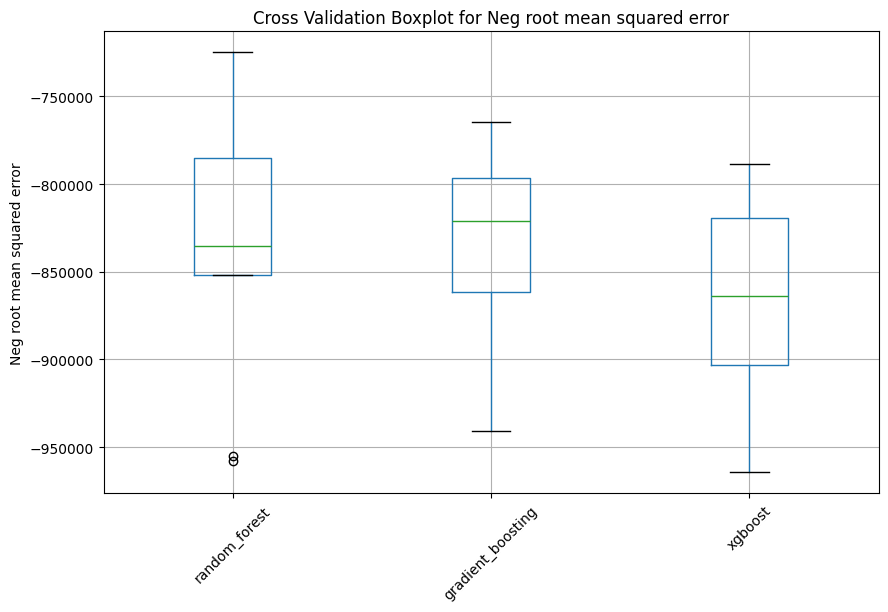

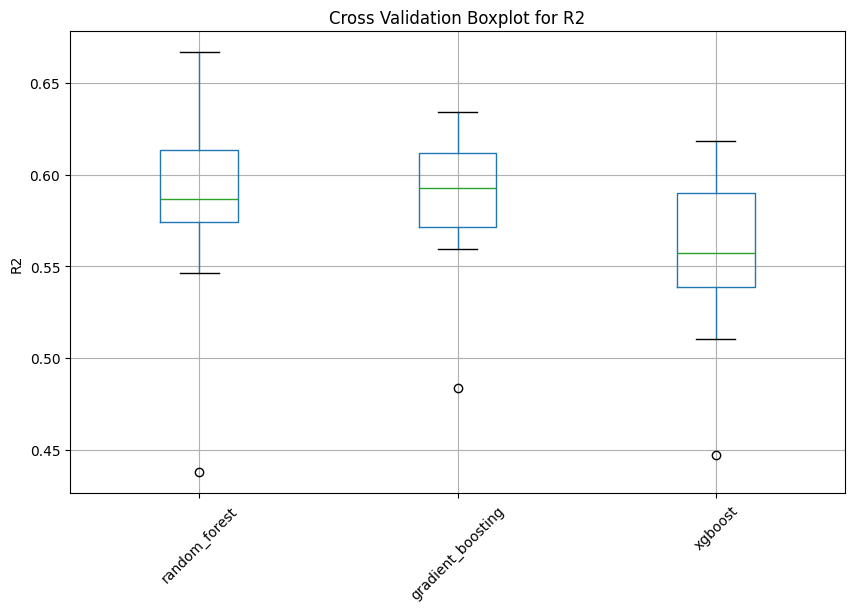

In [34]:
# Create a boxplot for the cross-validation results of each regression metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.replace('_', ' ').capitalize()}")
    plt.ylabel(f"{metric_name.replace('_', ' ').capitalize()}")
    plt.xticks(rotation=45)
    plt.show()

## ***Only one Metric (RMSE)***

For this regression task, the Root Mean Squared Error (RMSE) will be chosen as the primary evaluation metric. RMSE is preferred because it penalizes larger errors more than Mean Absolute Error (MAE), making it more sensitive to high deviations in housing prices. Given that price predictions can have significant variations, RMSE helps identify models that not only minimize errors but also ensure consistent and reliable predictions.

While R² provides insight into how well the model explains variance in the target variable, RMSE offers a more interpretable measure in absolute price units, which is crucial for practical applications in real estate pricing.

## ***Statistical Model Comparison***

In [35]:
result_df = cv_results_df["neg_root_mean_squared_error"]
result_df

,random_forest,gradient_boosting,xgboost
0,-780233.309210,-768405.941430,-818572.864621
1,-845444.457420,-864754.166203,-856239.207574
2,-851954.479031,-852660.958741,-910205.717724
3,-850796.353107,-820649.541304,-882708.202450
4,-794995.278948,-795539.140436,-789017.008821
5,-825356.900484,-798672.731954,-871599.742614
6,-955166.105933,-941109.915825,-964413.340140
7,-724898.048779,-764737.093892,-788516.765082
8,-958107.503043,-918315.076636,-950217.231471
9,-781653.857063,-821295.992899,-822700.072574


In [36]:
from scipy.stats import f_oneway

# Select the metric to analyze (RMSE, since it is our primary evaluation metric)
result_df = cv_results_df["neg_root_mean_squared_error"]

# Extract RMSE results for each model
model1 = result_df["random_forest"]
model2 = result_df["gradient_boosting"]
model3 = result_df["xgboost"]

# Perform ANOVA test
statistic, p_value = f_oneway(model1, model2, model3)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

# Set significance level
alpha = 0.05  

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation RMSE results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation RMSE results of the models."
    )

Statistic: 0.6800531985756801
p_value: 0.5150563696100781
There is no statistically significant difference in the cross-validation RMSE results of the models.


statistically all the models are similar, so two models are selected to be tuned in the next step:

✅ **Gradient Boosting** → Best RMSE, strong overall performance.

✅ **XGBoost** → Faster training time, similar RMSE to Random Forest.

## ***Hyperparameter tunning***
Select the best hyperparameters for the models selected in the previous step.

In [37]:
from sklearn.model_selection import GridSearchCV

### ***Gradient Boosting***

In [38]:
# Define the scoring metric (since RMSE is our main focus, we use "neg_root_mean_squared_error")
score = "neg_root_mean_squared_error"

# Hyperparameter tuning for Gradient Boosting
gb_params = {
    "model__n_estimators": [100, 300, 500],  # Number of boosting stages
    "model__learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
    "model__max_depth": [3, 5, 7]  # Maximum depth of trees
}

gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", GradientBoostingRegressor())])

grid_search_gb = GridSearchCV(
    gb_pipe, gb_params, cv=5, scoring=score, return_train_score=True, n_jobs=-1
)
grid_search_gb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'COMMERCIAL '
                                                                          'UNITS',
                                                                          'RESIDENTIAL '
                                                                          'UNITS']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHot...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['YEAR '
                                                                          'BUILT'])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [39]:
# Best parameters for Gradient Boosting
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 500}


***Evaluation Gradient Boosting***

In [40]:
# Train final Gradient Boosting model with the best hyperparameters
best_gb_model = GradientBoostingRegressor(
    learning_rate=0.01, max_depth=5, n_estimators=500, random_state=42
)

gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_gb_model)])
gb_final_model = gb_pipe.fit(x_train, y_train)

### ***XGBoost***

In [41]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7]
}

xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective="reg:squarederror", random_state=42))])

grid_search_xgb = GridSearchCV(
    xgb_pipe, xgb_params, cv=5, scoring=score, return_train_score=True, n_jobs=-1
)
grid_search_xgb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'COMMERCIAL '
                                                                          'UNITS',
                                                                          'RESIDENTIAL '
                                                                          'UNITS']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHot...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [42]:
# Best parameters for XGBoost
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}


***Evaluation XGBoost***

In [43]:
# Train final XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(
    learning_rate=0.1, max_depth=5, n_estimators=100, objective="reg:squarederror", random_state=42
)

xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_xgb_model)])
xgb_final_model = xgb_pipe.fit(x_train, y_train)

## ***Final Evaluation Test***

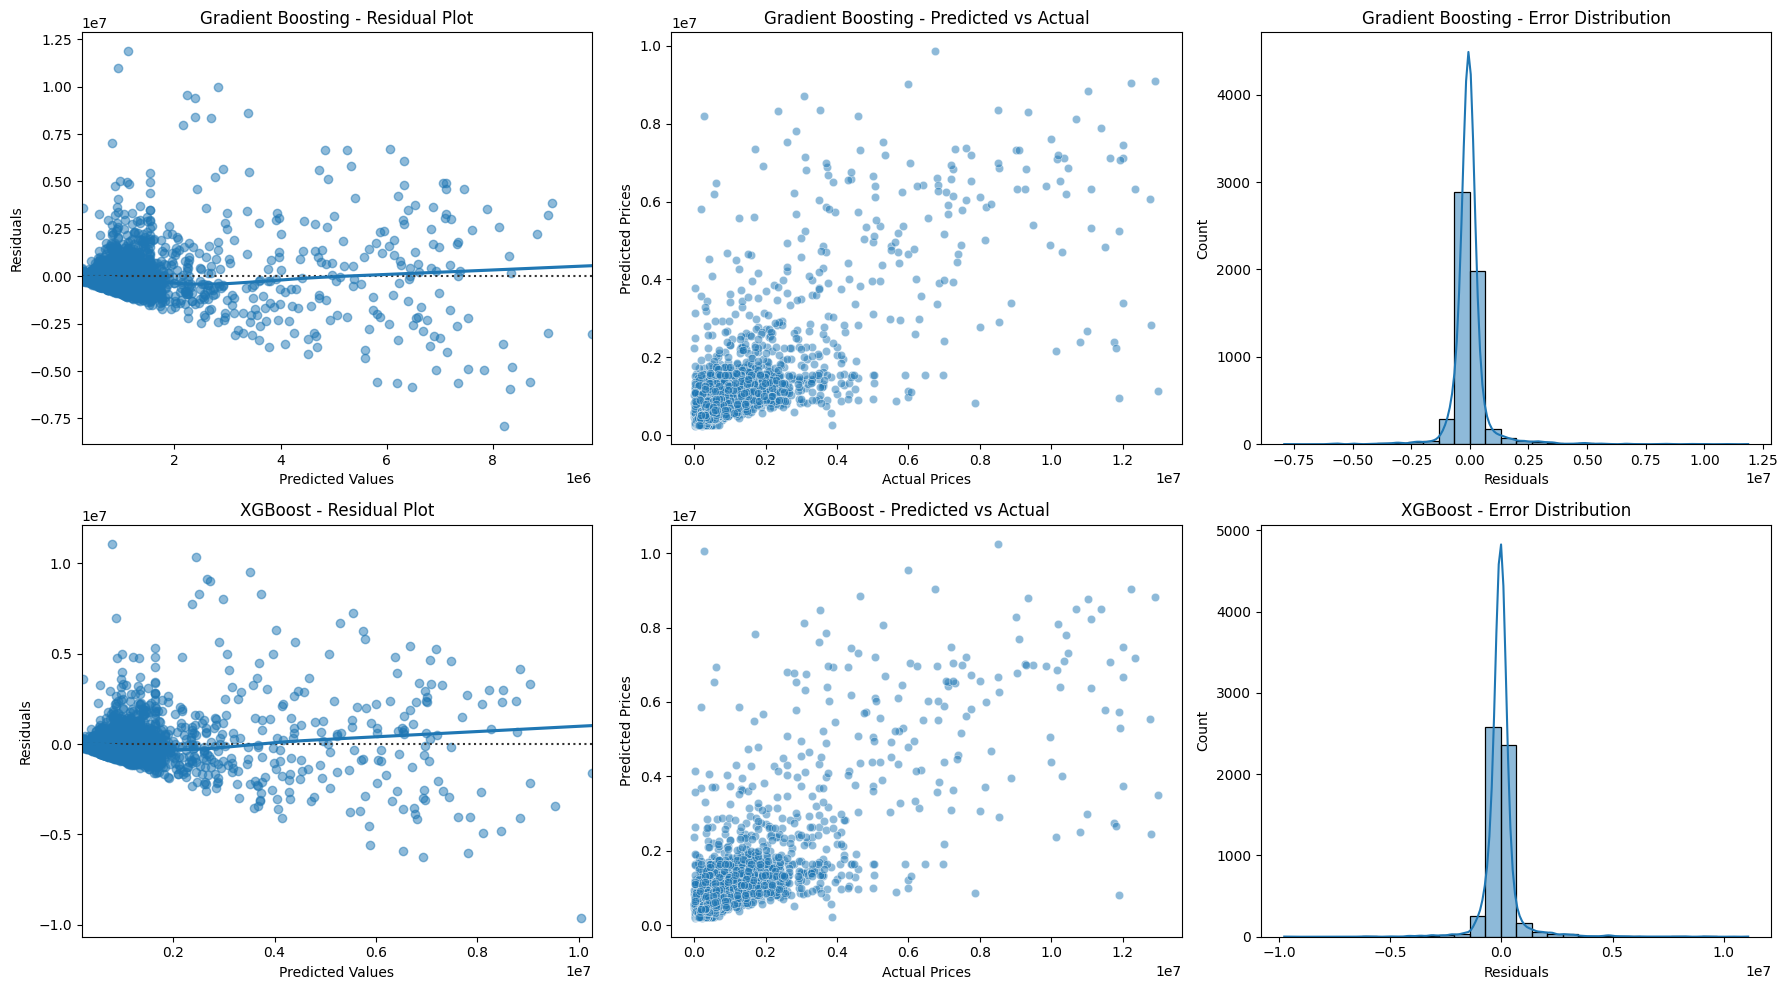

In [ ]:
import seaborn as sns

# Predictions
y_pred_gb = gb_final_model.predict(x_test)
y_pred_xgb = xgb_final_model.predict(x_test)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 📌 1. Residual Plot (Error vs. Predicted Values)
sns.residplot(
    x=y_pred_gb, 
    y=(y_test - y_pred_gb), 
    ax=axes[0, 0], 
    lowess=True, 
    scatter_kws={'alpha': 0.5}
)
axes[0, 0].set_title("Gradient Boosting - Residual Plot")
axes[0, 0].set_xlabel("Predicted Values")
axes[0, 0].set_ylabel("Residuals")

sns.residplot(
    x=y_pred_xgb, 
    y=(y_test - y_pred_xgb), 
    ax=axes[1, 0], 
    lowess=True, 
    scatter_kws={'alpha': 0.5}
)
axes[1, 0].set_title("XGBoost - Residual Plot")
axes[1, 0].set_xlabel("Predicted Values")
axes[1, 0].set_ylabel("Residuals")

# 📌 2. Predicted vs Actual Values
sns.scatterplot(
    x=y_test,
    y=y_pred_gb,
    ax=axes[0, 1],
    alpha=0.5
)
axes[0, 1].set_title("Gradient Boosting - Predicted vs Actual")
axes[0, 1].set_xlabel("Actual Prices")
axes[0, 1].set_ylabel("Predicted Prices")

sns.scatterplot(
    x=y_test, 
    y=y_pred_xgb, 
    ax=axes[1, 1], 
    alpha=0.5
)
axes[1, 1].set_title("XGBoost - Predicted vs Actual")
axes[1, 1].set_xlabel("Actual Prices")
axes[1, 1].set_ylabel("Predicted Prices")

# 📌 3. Error Distribution (Histogram of Residuals)
sns.histplot(
    y_test - y_pred_gb, 
    kde=True, 
    bins=30, 
    ax=axes[0, 2]
)
axes[0, 2].set_title("Gradient Boosting - Error Distribution")
axes[0, 2].set_xlabel("Residuals")

sns.histplot(
    y_test - y_pred_xgb, 
    kde=True, 
    bins=30, 
    ax=axes[1, 2]
)
axes[1, 2].set_title("XGBoost - Error Distribution")
axes[1, 2].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

### ***Model comparison***

Both Gradient Boosting and XGBoost exhibit similar performance in terms of RMSE and error distribution. However, ***XGBoost appears to have a slightly better error distribution***, with a more concentrated spread around zero, indicating greater stability in its predictions.

Additionally, while both models struggle with high-price predictions, XGBoost's tighter residual distribution suggests that it may generalize slightly better across different price ranges.

📌 ***Final Decision:***
Since the performance differences are minimal but XGBoost shows slightly better error control, ***XGBoost is selected*** as the best model for this dataset.

## ***XGBoost Learning Curve***

This curve is used to see if the model is overfitting or underfitting.

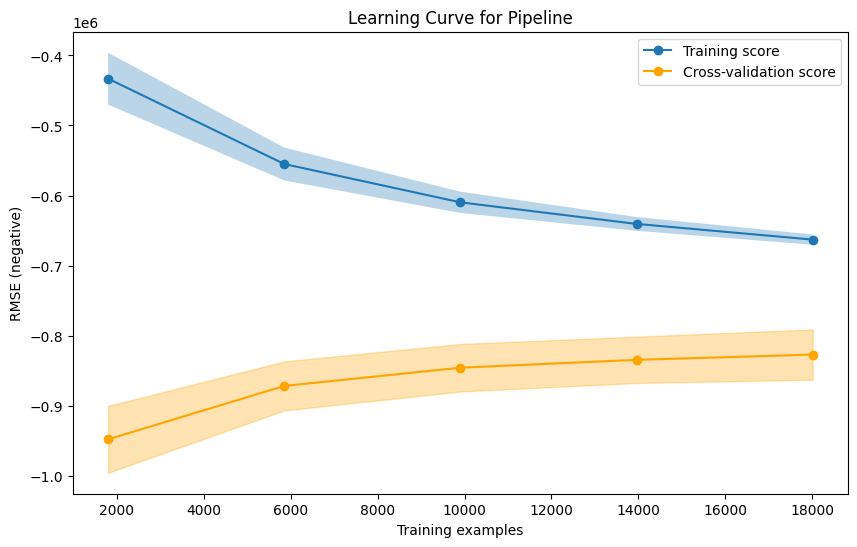

Training Sizes: [ 1801  5853  9905 13957 18010]
Training Scores Mean: [-433118.58278709 -554995.43144591 -609687.32870964 -640516.80261356
 -662903.80722562]
Training Scores Std: [37013.69182048 23501.66003765 15205.33277968  9807.97583781
  7339.04606649]
Test Scores Mean: [-948078.69666606 -871831.18591943 -845813.50530949 -834585.1072846
 -827078.26056148]
Test Scores Std: [47665.20597099 34953.97639172 33911.12439581 33017.82935728
 35880.02830201]


In [45]:
# Define the XGBoost model with the best hyperparameters
model = xgb_final_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "neg_root_mean_squared_error"  # RMSE (negative for optimization in sklearn)

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel("RMSE (negative)")
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

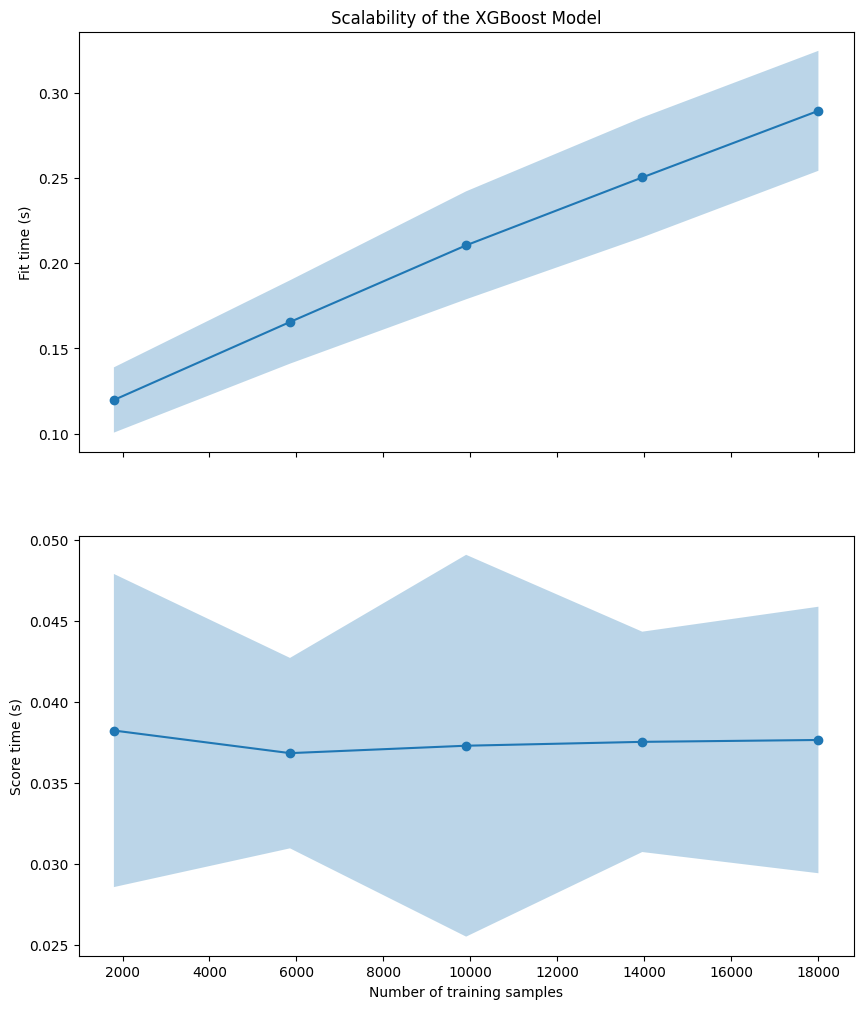

Fit Times Mean: [0.11973285 0.16550022 0.21047721 0.25028653 0.28939442]
Fit Times Std: [0.01914081 0.02445246 0.03166819 0.03516238 0.03518664]
Score Times Mean: [0.03823316 0.03683611 0.03729376 0.03753265 0.03764864]
Score Times Std: [0.00967242 0.00588203 0.01179327 0.00680616 0.00823205]


In [46]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the XGBoost Model")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

# 💾 ***Save the model***

In [47]:
from joblib import dump

# Save the complete pipeline (preprocessing + model)
dump(xgb_final_model, "nyc_houses_regression-xgboost-v1.joblib")

['nyc_houses_regression-xgboost-v1.joblib']

## ***Test the saved model***

In [48]:
from joblib import load

# Load the saved model (preprocessing + XGBoost)
my_model = load("nyc_houses_regression-xgboost-v1.joblib")

# test data
df_test = x_test.sample(5, random_state=42)
df_test


,COMMERCIAL UNITS,TAX CLASS AT TIME OF SALE,RESIDENTIAL UNITS,GROSS SQUARE FEET,BOROUGH,YEAR BUILT,LAND SQUARE FEET
28584,0,2.0,35,25925.0,2.0,1931.0,7500.0
27966,3,4.0,0,10500.0,4.0,2009.0,4988.0
21950,0,1.0,2,1632.0,4.0,1920.0,3135.0
22956,1,4.0,0,4504.0,3.0,1963.0,10000.0
10791,0,1.0,3,1232.0,4.0,1905.0,3072.0


In [49]:
# Make predictions with the loaded model
predictions = my_model.predict(df_test)

# Display the predictions
print("Predictions for first test samples:", predictions)

Predictions for first test samples: [4954563.5  4539557.5   627337.06 3253148.8   563366.06]


In [50]:
# Set pandas display options to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Assign the predictions to the DataFrame
df_test["SALE PRICE"] = predictions

# Display the DataFrame
df_test

,COMMERCIAL UNITS,TAX CLASS AT TIME OF SALE,RESIDENTIAL UNITS,GROSS SQUARE FEET,BOROUGH,YEAR BUILT,LAND SQUARE FEET,SALE PRICE
28584,0,2.00,35,25925.00,2.00,1931.00,7500.00,4954563.50
27966,3,4.00,0,10500.00,4.00,2009.00,4988.00,4539557.50
21950,0,1.00,2,1632.00,4.00,1920.00,3135.00,627337.06
22956,1,4.00,0,4504.00,3.00,1963.00,10000.00,3253148.75
10791,0,1.00,3,1232.00,4.00,1905.00,3072.00,563366.06


# 📊 ***Analysis of Results***

The learning curve analysis indicates that the model is generalizing well, with a stable gap between training and validation RMSE. The model has a lower RMSE on training data (-662,903) compared to validation (-827,078), showing that it has some room for improvement but is not severely overfitting.

## 📈***Learning Curve Insights***
- The training score decreases as more data is used, meaning the model becomes more generalized.
- The validation score improves as the dataset grows, but the gap between training and validation suggests potential underfitting.
- The learning curve does not completely flatten out, implying that adding more data could still improve the model.

# 🧑‍🔬 ***Recommendations***
1️⃣ ***Continue using XGBoost***

- The learning curve suggests it benefits from more data, so increasing the dataset may improve performance.

2️⃣ ***Consider Ensembling Approaches***

- Combining XGBoost with Gradient Boosting or Random Forest may improve robustness and generalization.
- An ensemble model could be tested to see if it reduces prediction variance.

# 🚀 ***Final Conclusion***
✅ XGBoost is a strong candidate for this regression problem. It maintains efficiency while making reasonably accurate predictions. Some minor underfitting exists, meaning more data or feature engineering could further enhance its performance.